In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [94]:
CLOSE = "Close_BTC"

include = [
    'Close_BTC',
    'Close_DOT',
    'Close_ETH',
    'NASDAQComposite',
    'Close_BNB',
    'SP500',
    'Close_ADA',
    'Close_XRP',
    'Close_DOGE'
]

In [95]:
# Load data
dataset_pickle = '../data/federalfinancegestion/dataset.pkl'
df = pd.read_pickle(dataset_pickle)
df.fillna(0, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

start_date_training = pd.to_datetime('2017-08-01')
end_date_training = pd.to_datetime('2022-08-31')
start_date_testing = pd.to_datetime('2022-09-01')
end_date_testing = pd.to_datetime('2023-04-30')

In [96]:
train_df = df.loc[start_date_training:end_date_training]
test_df = df.loc[start_date_testing:end_date_testing]

In [97]:
# Calculating the logarithmic difference of 'Close'
df['Close_Log'] = np.log(df[CLOSE])  # First, compute the log of 'Close'
df['Log_Diff_Close'] = df['Close_Log'].diff().fillna(0)  # Then compute the difference and handle NaN

In [98]:
# Include features
train = train_df[include].values
test = test_df[include].values

In [99]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [100]:
# # # SDAE
input_layer = Input(shape=(len(include),))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(include), activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(train_scaled, train_scaled, epochs=150, batch_size=32, shuffle=True, validation_split=0.2)

# Get the encoded representation of the data
encoded_features = autoencoder.predict(train_scaled)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days used to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(include)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(include)))

Epoch 1/150


33/33 [==============================] - 1s 4ms/step - loss: 0.1150 - val_loss: 0.0665
Epoch 2/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0209
Epoch 3/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0157
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0130
Epoch 5/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 6/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0135
Epoch 7/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0140
Epoch 8/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0139
Epoch 9/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0136
Epoch 10/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 11/150
33/33 [=

In [101]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(include))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 50)             12000     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_24 (Dense)            (None, 25)                1275      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 33501 (130.86 KB)
Trainable params: 33501 (130.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150


21/21 [==============================] - 3s 4ms/step - loss: 0.0560
Epoch 2/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 3/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 4/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 5/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 6/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 7/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/150
21/21 [==============================] - 0s 4ms/step - loss: 9.9831e-04
Epoch 13/150
21/21 [=========================

In [105]:
# Predict values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(include)-1))), axis=1))[:, 0]

# Slice the actual prices to align with the predictions
actual_prices_aligned = df.loc[start_date_testing:end_date_testing, CLOSE][-len(predictions):]
predictions = pd.DataFrame(predictions, index=actual_prices_aligned.index, columns=['Predicted_Close'])

# Convert actual_prices_aligned to a DataFrame
actual_prices_aligned_df = pd.DataFrame(actual_prices_aligned, columns=[CLOSE])

# Calculating the logarithm of predictions and then the logarithmic difference
actual_prices_aligned_df['Predicted_Close'] = predictions
actual_prices_aligned_df['Predicted_Close'] = np.log(actual_prices_aligned_df['Predicted_Close'])
log_diff_predicted = actual_prices_aligned_df['Predicted_Close'].diff().fillna(0)
log_diff_actual = pd.DataFrame(df["Log_Diff_Close"], index=actual_prices_aligned.index, columns=['Log_Diff_Close'])

5/5 [==============================] - 0s 2ms/step


In [106]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual_prices_aligned, predictions))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE
mae = mean_absolute_error(actual_prices_aligned, predictions)
print('Mean Absolute Error (MAE):', mae)

Root Mean Squared Error (RMSE): 949.067570333657
Mean Absolute Error (MAE): 739.9199353206552


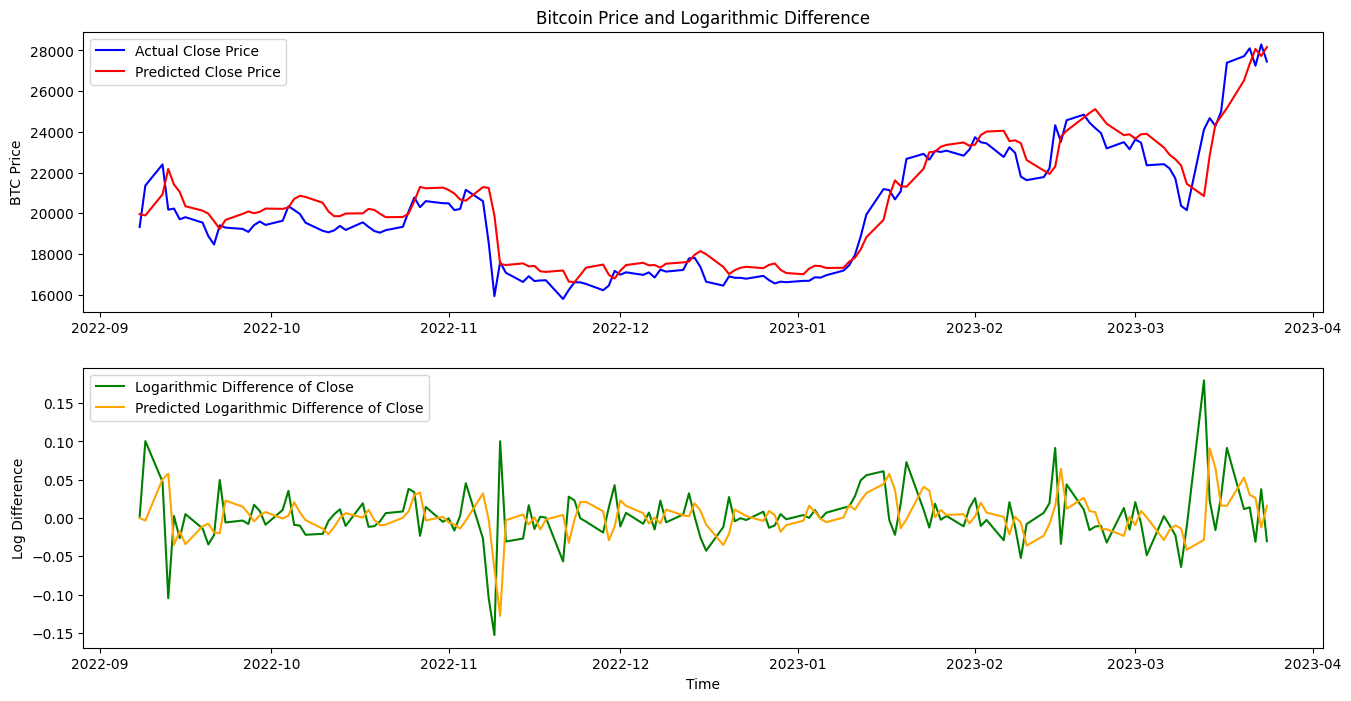

In [107]:
# Existing plot for 'Close' prices
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)  # First subplot in a 2x1 grid
plt.plot(actual_prices_aligned, label='Actual Close Price', color='blue')
plt.plot(predictions, label='Predicted Close Price', color='red')
plt.title('Bitcoin Price and Logarithmic Difference')
plt.ylabel('BTC Price')
plt.legend()

# New plot for 'Log_Diff_Close'
plt.subplot(2, 1, 2)  # Second subplot in a 2x1 grid
plt.plot(log_diff_actual, label='Logarithmic Difference of Close', color='green')
plt.plot(log_diff_predicted, label='Predicted Logarithmic Difference of Close', color='orange')
plt.xlabel('Time')
plt.ylabel('Log Difference')
plt.legend()

plt.show()